In [88]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import model_selection

# Load data

In [89]:
# Mikel path
df = pd.read_csv('/Users/mikelyu/Desktop/Uni/02455 Statistical Evaluation/02455-projects/HR_data.csv')

# Karl path
#df = pd.read_csv(r"C:\desktop\02455-projects\HR_data.csv")

# Display the first few rows of the dataset
print(df.head())

   Unnamed: 0    HR_Mean  HR_Median    HR_std  HR_Min  HR_Max     HR_AUC  \
0           0  77.965186      78.00  3.345290   73.23   83.37  22924.945   
1           1  70.981097      70.57  2.517879   67.12   78.22  21930.400   
2           2  73.371959      73.36  3.259569   67.88   80.22  21647.085   
3           3  78.916822      77.88  4.054595   72.32   84.92  25258.905   
4           4  77.322226      74.55  6.047603   70.52   90.15  23890.565   

     Round   Phase  Individual  Puzzler  Frustrated Cohort  
0  round_3  phase3           1        1           1   D1_1  
1  round_3  phase2           1        1           5   D1_1  
2  round_3  phase1           1        1           0   D1_1  
3  round_2  phase3           1        1           1   D1_1  
4  round_2  phase2           1        1           5   D1_1  


In [90]:
# Check for missing values
print(df.isnull().sum())


Unnamed: 0    0
HR_Mean       0
HR_Median     0
HR_std        0
HR_Min        0
HR_Max        0
HR_AUC        0
Round         0
Phase         0
Individual    0
Puzzler       0
Frustrated    0
Cohort        0
dtype: int64


No missing values.

In [91]:
for column in df.columns:
    globals()[column] = df[column].tolist()

# visualization

(array([29., 45., 31., 16.,  0., 23., 14.,  5.,  2.,  3.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

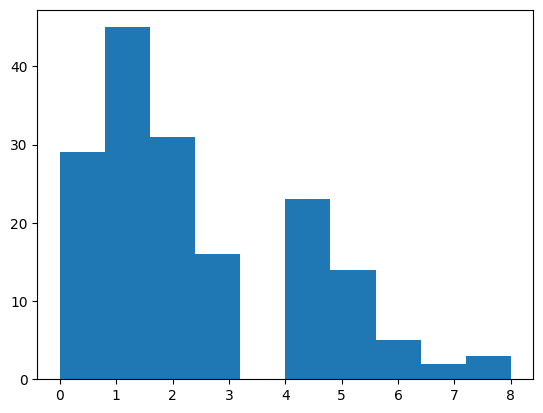

In [92]:
plt.hist(Frustrated)

Frustration is discrete variable. Therefore, each value from 0-10 can be seen as a discrete and separated value. We can thus view this as a classification problem. Therefore, we will attempt to fit two classification models to the data.

# Models

## Classification

In [93]:
# Display the first few rows of the dataframe
print(df.head())

# Display information about the dataframe
print(df.info())

X = df.drop(["Unnamed: 0",'Frustrated',"Individual","Puzzler","Cohort","Phase","Round"], axis=1)

X

   Unnamed: 0    HR_Mean  HR_Median    HR_std  HR_Min  HR_Max     HR_AUC  \
0           0  77.965186      78.00  3.345290   73.23   83.37  22924.945   
1           1  70.981097      70.57  2.517879   67.12   78.22  21930.400   
2           2  73.371959      73.36  3.259569   67.88   80.22  21647.085   
3           3  78.916822      77.88  4.054595   72.32   84.92  25258.905   
4           4  77.322226      74.55  6.047603   70.52   90.15  23890.565   

     Round   Phase  Individual  Puzzler  Frustrated Cohort  
0  round_3  phase3           1        1           1   D1_1  
1  round_3  phase2           1        1           5   D1_1  
2  round_3  phase1           1        1           0   D1_1  
3  round_2  phase3           1        1           1   D1_1  
4  round_2  phase2           1        1           5   D1_1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC
0,77.965186,78.000,3.345290,73.23,83.37,22924.945
1,70.981097,70.570,2.517879,67.12,78.22,21930.400
2,73.371959,73.360,3.259569,67.88,80.22,21647.085
3,78.916822,77.880,4.054595,72.32,84.92,25258.905
4,77.322226,74.550,6.047603,70.52,90.15,23890.565
...,...,...,...,...,...,...
163,73.594539,72.380,9.474556,57.43,93.53,21482.985
164,57.839897,54.130,6.796647,52.97,74.14,16825.740
165,64.237295,65.195,3.589241,58.97,72.63,18691.065
166,70.834320,70.440,2.391160,66.65,76.07,20753.005


In [94]:
# Predicting Frustrated
y = df['Frustrated']

In [95]:
from sklearn.preprocessing import StandardScaler

numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Check mean and standard deviation
print(X[numeric_columns].mean())
print(X[numeric_columns].std())


HR_Mean      2.379049e-16
HR_Median   -7.850863e-16
HR_std      -5.815454e-17
HR_Min      -8.035900e-16
HR_Max      -1.015061e-15
HR_AUC      -4.546628e-16
dtype: float64
HR_Mean      1.00299
HR_Median    1.00299
HR_std       1.00299
HR_Min       1.00299
HR_Max       1.00299
HR_AUC       1.00299
dtype: float64


In [96]:
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define the groups based on the 'Individual' column

groups = df['Individual']

# Leave One Group Out Cross-Validation
logo = LeaveOneGroupOut()


# Model
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression(random_state=42, max_iter=100000)


# Cross-Validation Scores
scores_model1 = cross_val_score(model1, X, y, cv=logo, groups=groups, scoring='accuracy')
scores_model2 = cross_val_score(model2, X, y, cv=logo, groups=groups, scoring='accuracy')

# Display Scores
print(f'Logistic Regression LOGO CV accuracy: {np.mean(scores_model1):.4f}')
print(f'Random Forest LOGO CV accuracy: {np.mean(scores_model2):.4f}')

Logistic Regression LOGO CV accuracy: 0.1488
Random Forest LOGO CV accuracy: 0.1726


# Evaluation

In [99]:
from scipy.stats import ttest_ind

# Perform a t-test to compare the performances of the two models
t_stat, p_value = ttest_ind(scores_model1, scores_model2)

print(f'T-test statistic: {t_stat:.4f}, p-value: {p_value:.4f}')

T-test statistic: -0.5605, p-value: 0.5799
